# Getting Started SNN!

## From Neuron to Learning Network

In [1]:
import numpy as np

from matplotlib import pyplot as plt
from snn.spiking_neuron import create_SCTN


### The SCTN

#### Membrane Potential

Initiating simple SCTN neuron

In [2]:
neuron = create_SCTN()

Spiking neurons are getting spikes as input, the neruons are connected with synapses and each synapse has weight. To define how many synapse and what its corresponded weight you need to set it using synapses_weights

Lets set the neuron with 1 synapse with weight of 10.

In [3]:
neuron.synapses_weights = np.array([10])

The SCTN has 3 different activation functions, lets use the `BINARY` activation function which is simlar how the LIF neuron model works and set the threshold to emit spike to 100.

In [4]:
from snn.spiking_neuron import BINARY

neuron.activation_function = BINARY
neuron.threshold_pulse = 100

The SCTN has several parameters, include leakage-factor and leakage-period that control the leakage of the membrane.
The neuron has inner timer that increase every tick, when the timer count to `leakage_period` the timer set back to 0 and the membrane reduce by (`membrane_potential / 2 ** leakage_factor`)
Lets set `leakage_factor` to 1 and `leakage_period` to 1.

In [5]:
neuron.leakage_factor = 1
neuron.leakage_period = 1

SCTN is type of LIF Model!
Let's see how it works.
First set the neuron to save its values through time. the membrane potential.

In [6]:
neuron.log_membrane_potential = True

Now lets watch what happened after a spike

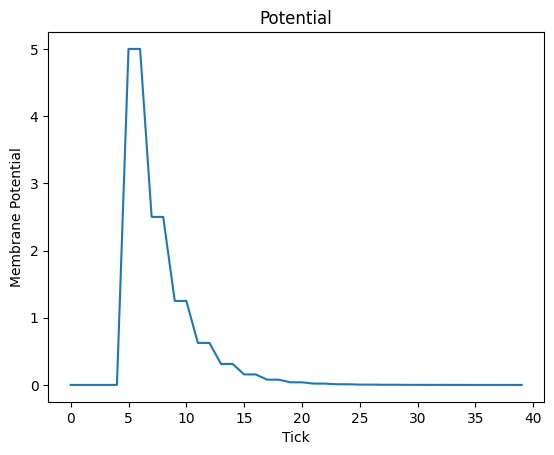

In [7]:
def simulate_membrane_leakage():
    spikes_input = np.zeros(40)
    spikes_input[5] = 1

    for s in spikes_input:
        # neuron may have several inputs from different source so the input should be wrapped in another array
        neuron.ctn_cycle(np.array([s]), True)


    membrane_potential = neuron.membrane_potential_graph()
    plt.plot(membrane_potential)
    plt.ylabel('Membrane Potential')
    plt.xlabel('Tick')
    plt.title("Potential")

neuron.forget_logs()
simulate_membrane_leakage()

You see how the potential decrease every tick. You can delay the decrease using the `leakage_period`

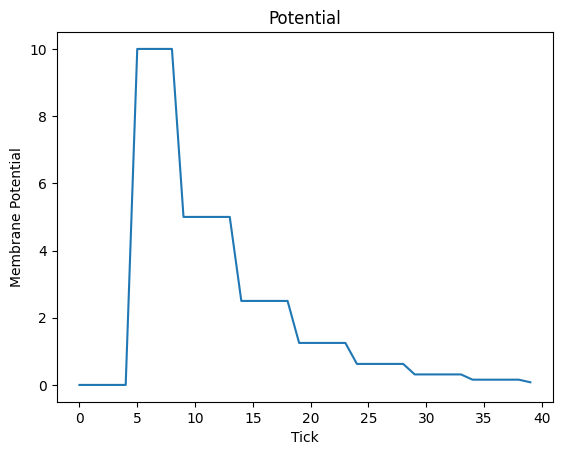

In [8]:
neuron.leakage_period = 4

neuron.forget_logs()
simulate_membrane_leakage()

You also can make the decrease less aggressive with `leakage_factor`.
*Be aware that leakage_factor affect the weight of the input*

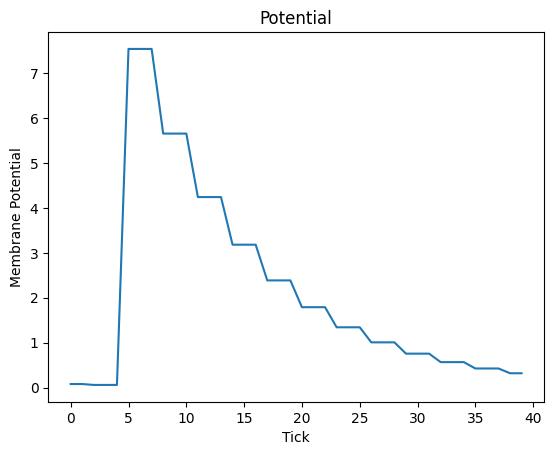

In [9]:
neuron.leakage_factor = 2
neuron.leakage_period = 2

neuron.forget_logs()
simulate_membrane_leakage()

#### Emitting Spike

Neuron that doesn't emit spikes is dead neuron! So, let's make neuron that emit spikes.

In [10]:
neuron = create_SCTN()
neuron.leakage_factor = 2
neuron.leakage_period = 2
neuron.threshold_pulse = 50
neuron.activation_function = BINARY
neuron.log_membrane_potential = True
neuron.synapses_weights = np.array([10])

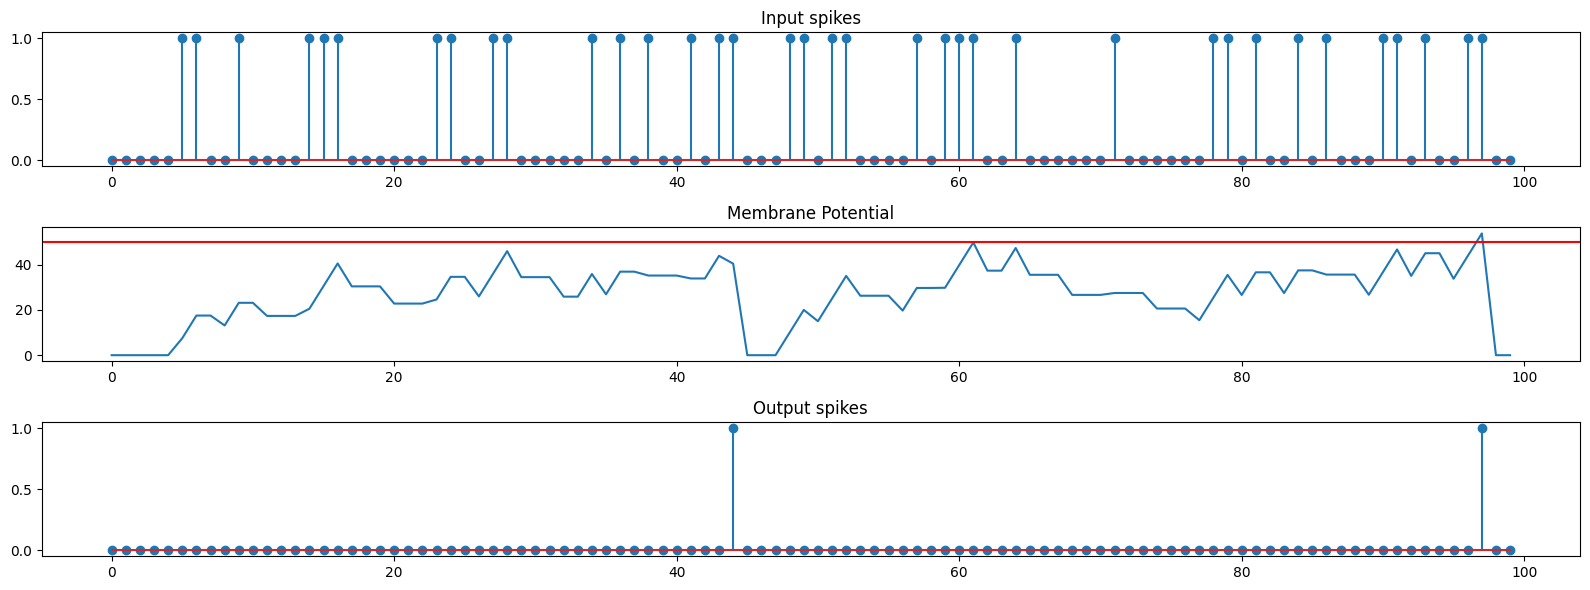

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(16, 6))
spikes_input = np.zeros(100)
spikes_input[np.random.choice(np.arange(100), 45)] = 1
spikes_output = np.zeros(100)

for i, s in enumerate(spikes_input):
    # neuron may have several inputs from different source so the input should be wrapped in another array
    spikes_output[i] = neuron.ctn_cycle(np.array([s]), True)

membrane_potential = neuron.membrane_potential_graph()

axs[0].set_title('Input spikes')
axs[0].stem(spikes_input)
axs[1].set_title('Membrane Potential')
axs[1].plot(membrane_potential)
axs[1].axhline(neuron.threshold_pulse, xmin=0, xmax=200, color='r')
axs[2].set_title('Output spikes')
axs[2].stem(spikes_output)
fig.tight_layout()

* Note that the plot of the membrane is after each tick, if spike is emitted than the membrane is reduced and this is what logged.

### The Network

SCTN by itself not helping much, the real beauty of SNN starts when you connect neurons together.
Create SpikingNetwork is simple as that:

In [13]:
from snn.spiking_network import SpikingNetwork
network = SpikingNetwork()

The network is built by layers.
This is a network with 1 layer with 1 neuron.

Text(0.5, 1.0, 'Plot of 1 neuron')

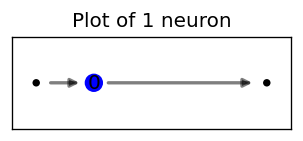

In [14]:
from snn.graphs import plot_network
from snn.layers import SCTNLayer

network.add_layer(SCTNLayer([create_SCTN()]))

plot_network(network)
plt.title('Plot of 1 neuron')

Text(0.5, 1.0, 'Add layer with 4 neurons')

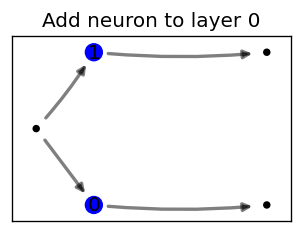

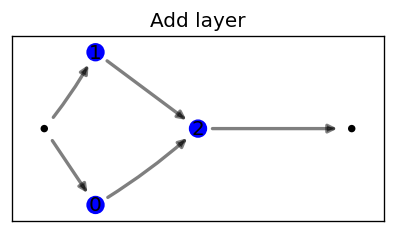

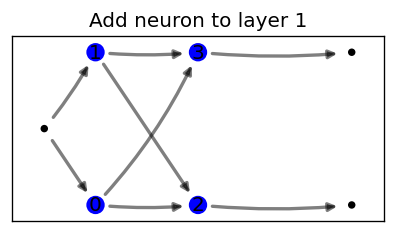

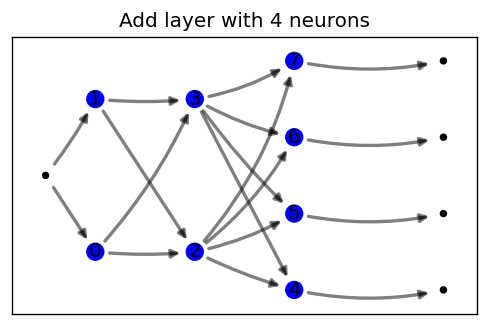

In [15]:

network.add_neuron(create_SCTN(), 0)
plot_network(network)
plt.title('Add neuron to layer 0')

network.add_layer(SCTNLayer([create_SCTN()]))
plot_network(network)
plt.title('Add layer')

network.add_neuron(create_SCTN(), 1)
plot_network(network)
plt.title('Add neuron to layer 1')

network.add_layer(SCTNLayer([create_SCTN() for i in range(4)]))
plot_network(network)
plt.title('Add layer with 4 neurons')

###  Simulate network

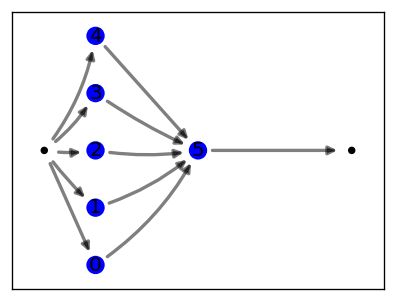

In [17]:
def new_neuron():
    neuron = create_SCTN()
    neuron.leakage_factor = 2
    neuron.leakage_period = 2
    neuron.log_out_spikes = True
    neuron.threshold_pulse = 50
    neuron.activation_function = BINARY
    neuron.log_membrane_potential = True
    # make different neurons using random weights
    neuron.synapses_weights = np.array(10 + (10 * np.random.random(1)))
    return neuron

network = SpikingNetwork()
network.add_layer(SCTNLayer([new_neuron() for i in range(5)]))
network.add_layer(SCTNLayer([new_neuron()]))
plot_network(network)

In [18]:
spikes_input = np.zeros(100)
spikes_input[np.random.choice(np.arange(len(spikes_input)), 45)] = 1
spikes_layer_1 = np.zeros((len(spikes_input), len(network.layers_neurons[0].neurons)))

for i, s in enumerate(spikes_input):
    # neuron may have several inputs from different source so the input should be wrapped in another array
    network.input(s)

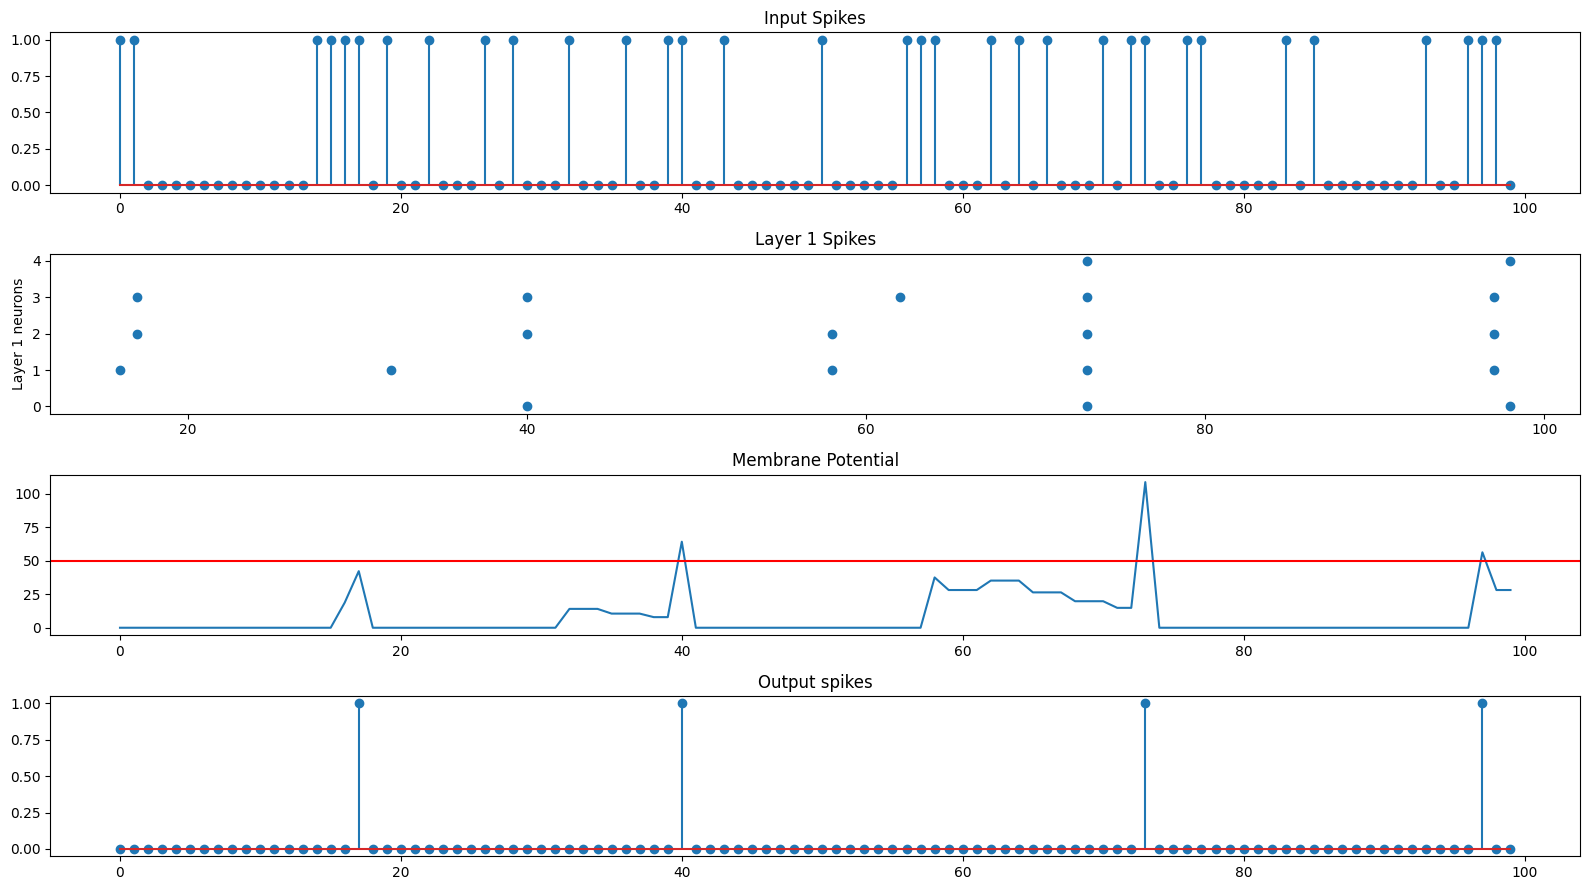

In [19]:
fig, axs = plt.subplots(4, 1, figsize=(16, 9))

for i, neuron in enumerate(network.layers_neurons[0].neurons):
    spikes_layer_1[:, i] = neuron.out_spikes(is_timestamps=False, spikes_array_size=len(spikes_input))

output_neuron = network.neurons[-1]
membrane_potential = output_neuron.membrane_potential_graph()
spikes_output = output_neuron.out_spikes(is_timestamps=False, spikes_array_size=len(spikes_input))

axs[0].set_title('Input Spikes')
axs[0].stem(spikes_input)
axs[1].set_title('Layer 1 Spikes')
axs[1].set_ylabel('Layer 1 neurons')
axs[1].scatter(*np.where(spikes_layer_1 == 1))
axs[2].set_title('Membrane Potential')
axs[2].plot(membrane_potential)
axs[2].axhline(output_neuron.threshold_pulse, xmin=0, xmax=200, color='r')
axs[3].set_title('Output spikes')
axs[3].stem(spikes_output)
fig.tight_layout()

### The Learning Algorithm - STDP
Synapses are plasticity, means they can adopt by increasing or decreasing its weights

This time, you create a neuron that will learn to be a maximum function

First lets implement spikes input that represent sin, we can do it in several ways. I'll do it using random function.
The density of the spikes correlated to sin function.

*Note that there is a shift between the sine wave vs the density of spikes to the sign wave because of the sliding window that im using. let's ignore this shift*

#### Input

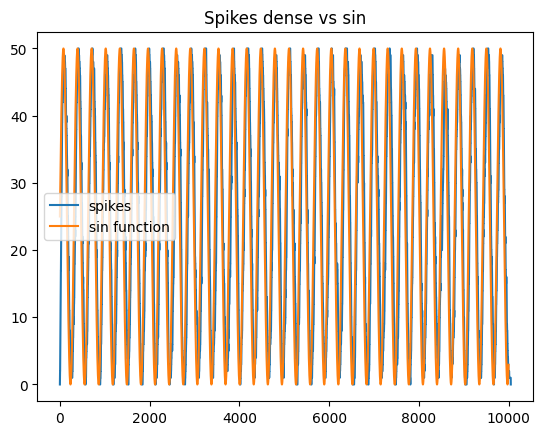

In [20]:
INPUT_SIZE = 10000
FREQ = 50
sine_input = np.random.random(INPUT_SIZE) < (1 + np.sin(np.arange(INPUT_SIZE) / FREQ))/2

y1 = np.convolve(sine_input, np.ones(FREQ))
plt.plot(y1, label='spikes')
plt.plot((1 + np.sin(np.arange(INPUT_SIZE) / FREQ)) * FREQ / 2, label='sin function')
plt.title('Spikes dense vs sin')
plt.legend()

Now let's do the same with cosine wave as the opposite input.

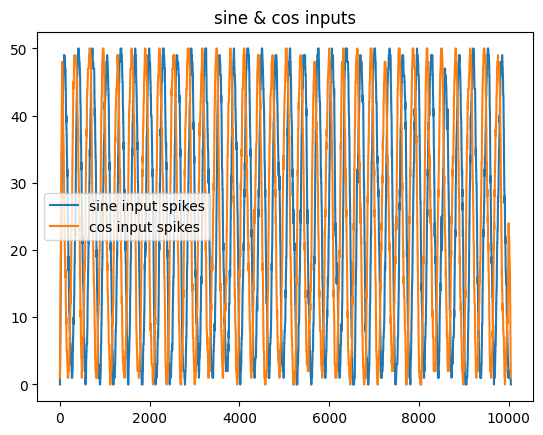

In [21]:
cos_input = (np.random.random(INPUT_SIZE)) < (1 + np.cos(np.arange(INPUT_SIZE) / FREQ))/2

y2 = np.convolve(cos_input, np.ones(FREQ))
plt.plot(y1, label='sine input spikes')
plt.plot(y2, label='cos input spikes')
plt.title('sine & cos inputs')
plt.legend()

In [22]:
# concatenate the inputs to the network
spikes_input = np.stack([sine_input, cos_input]).T
spikes_input.shape

(10000, 2)

In [26]:
clk_freq = 1536000
network = SpikingNetwork()

neuron = create_SCTN()
neuron.theta = -.1
neuron.synapses_weights = np.array([5, 5], dtype=np.float64)
neuron.leakage_factor = 5
neuron.leakage_period = 72
neuron.threshold_pulse = 300
neuron.membrane_sample_max_window = np.zeros(1).astype('float32')
neuron.activation_function = BINARY

time_to_learn = 2.5e-3
A_LTP = .00025
A_LTD = -.00015
tau = clk_freq * time_to_learn / 2
neuron.set_stdp(A_LTP, A_LTD, tau, clk_freq, 100, 0)

network.add_layer(SCTNLayer([neuron]))
network.log_out_spikes(-1)
network.log_membrane_potential(-1)
network.input_full_data_spikes(spikes_input)
spikes_output = network.neurons[-1].out_spikes(is_timestamps=False, spikes_array_size=len(spikes_input))
dense_output = np.convolve(spikes_output, np.ones(50))

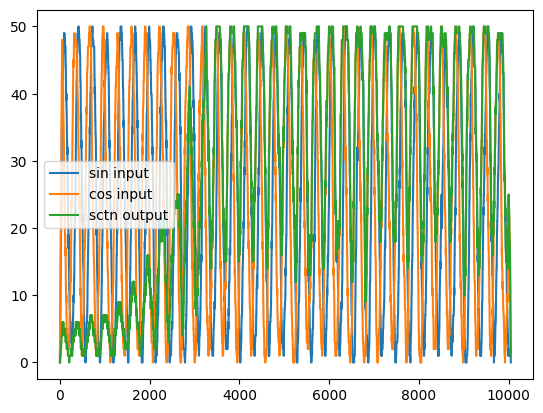

In [27]:
plt.plot(y1, label='sin input')
plt.plot(y2, label='cos input')
plt.plot(dense_output, label='sctn output')
plt.legend()

You see how it learns by time? let's zoom in.

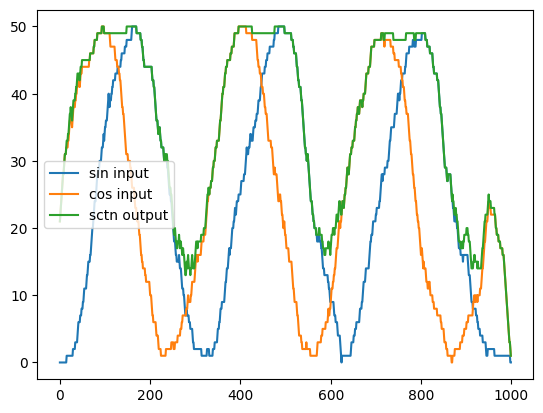

In [28]:
plt.plot(y1[-1000:], label='sin input')
plt.plot(y2[-1000:], label='cos input')
plt.plot(dense_output[-1000:], label='sctn output')
plt.legend()

## Summary
We have implemented a simple neuron and see its functionality!
We also connect neurons with others to create a network.
One last thing we make a neuron to learn with STDP!